# Analyze Reddit Populations and IRA Trolls

This script performs end-to-end analysis around the ideological characterization of Reddit populations compared to IRA accounts.

This script proceeds as follows:
1. collect posts from random, politically engaged, and IRA troll populations, 
2. plot their frequency, 
3. Extract URL links posted by these populations,
4. Unshorten these links,
5. Use Greg Eady's MediaScores method to score links by ideology,
6. Plot the time series of average ideologies across these populations,
7. Score YouTube channels shared by these populations,
8. Pot the time series of YouTube ideology  across these populations,
9. Infer individual-level ideologies based on mean link ideologies shared by that individual, and
10. Compare the change in ideological behavior of these accounts over time

In [1]:
%matplotlib inline

In [2]:
import json
import string
import datetime
import requests
import tldextract
import matplotlib
import urlexpander

import scipy.stats

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [3]:
import sklearn.metrics
import sklearn.preprocessing
import sklearn.feature_extraction

import nltk.tokenize
import nltk.tokenize.casual

from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors

In [4]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/clb617/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
def normalize(s):
    """
    Given a text, cleans and normalizes it. Feel free to add your own stuff.
    From: https://www.kaggle.com/mschumacher/using-fasttext-models-for-robust-embeddings
    """
    s = s.lower()

    # Replace numbers and symbols with language
    s = s.replace('&', ' and ')
    s = s.replace('@', ' at ')
    s = s.replace('0', 'zero')
    s = s.replace('1', 'one')
    s = s.replace('2', 'two')
    s = s.replace('3', 'three')
    s = s.replace('4', 'four')
    s = s.replace('5', 'five')
    s = s.replace('6', 'six')
    s = s.replace('7', 'seven')
    s = s.replace('8', 'eight')
    s = s.replace('9', 'nine')

    return s

In [6]:
# Skip stop words, retweet signs, @ symbols, and URL headers
stopList = ["http", "https", "rt", "@", ":", "t.co", "co", "amp", "&amp;", "...", "\n", "\r"]
stopList.extend(string.punctuation)
# stopList.extend(stopwords.words("english"))

vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    tokenizer=nltk.tokenize.casual.casual_tokenize,
    ngram_range=(1, 1),
    stop_words=stopList, #We do better when we keep stopwords
    use_idf=True,
    smooth_idf=False,
    norm=None, #Applies l2 norm smoothing
    decode_error='replace',
    max_features=10000,
    min_df=4,
    max_df=0.501
    )

analyzer = vectorizer.build_analyzer()
def ft_tokenizer(text):
    return [normalize(t) for t in analyzer(text)]

In [7]:
# Convert JSON to a dict, returning None on fail for filtering
def json_str_to_reddit_sub(json_str):
    submission = None
    try:
        submission = json.loads(json_str)
        
        # Throw away comments. All submissions should have an is_self field
        if ( "is_self" not in submission ):
            submission = None
    except:
        pass
    
    return submission


In [8]:
# Only keep submissions posted between these limits
end_limit = datetime.datetime(2017, 1, 1)
start_limit = datetime.datetime(2013, 1, 1)

def time_filter(submission):
    created_time = submission["created_utc"]
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return (d >= start_limit and d < end_limit)

In [9]:
# remove self posts, so return true IF THIS IS NOT A SELF POST
def filter_self_text(sub):
    return not sub["is_self"]

In [10]:
def embed_map_partitions(sub_iter):

    model_gensim = FastText.load('/home/clb617/models/text_sample_2013to2016_gensim_200.model')

    wvs = model_gensim.wv

    def vectorize(sentence):
        tokenized = [normalize(t) for t in analyzer(sentence)]

        wv_vecs = []
        for t in tokenized:

            try:
                v = wvs[t]
                norm = np.linalg.norm(v)
                normed_v = (v / norm)
                wv_vecs.append(normed_v)
            except:
                continue

        normed_m = None
        if ( len(wv_vecs) > 0 ):
            m = np.array(wv_vecs)
            normed_m = np.mean(m, axis=0)

        return normed_m
    
    user_tups = []
    for sub in sub_iter:
        user_id = sub["author"]
        text = sub["title"]
        
        if ( text == "[deleted]" ):
            text = ""
            
#         if ( "selftext" in sub and len(sub["selftext"]) > 0 and sub["selftext"] != "[deleted]" ):
#             text = text + ". " + sub["selftext"]
            
        if ( len(text) > 0 ):
            sent_vecs = [
                vectorize(s) 
                for s in nltk.tokenize.sent_tokenize(text) if len(s) > 0
            ]
            filtered_vecs = [v for v in sent_vecs if v is not None]
            
            if ( len(filtered_vecs) > 0 ):
                vec = np.mean(filtered_vecs, axis=0)

                user_tups.append((user_id, vec))
    
    return iter(user_tups)


In [11]:
politically_relevant_ids = set()
for infile in [
    "policy_labels_reddit_random.csv",
    "policy_labels_reddit_poli.csv",
    "policy_labels_reddit_ira.csv",
]:
    local_policy_df = pd.read_csv(infile)
    positive_ids = set(local_policy_df[local_policy_df.label == 1]["sub_id"])
    
    politically_relevant_ids = politically_relevant_ids.union(positive_ids)
    print("Political Submissions:", len(politically_relevant_ids))

Political Submissions: 119207
Political Submissions: 535787
Political Submissions: 544908


In [12]:
politically_relevant_ids_broad = sc.broadcast(politically_relevant_ids)

In [13]:
# Read submissions, remove duplicates, filter by time/self-text, and embed
random_sample_rows_rdd = sc.textFile("usertimeline/reddit_random_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .mapPartitions(embed_map_partitions)\
    .combineByKey(lambda value: (value, 1),
                  lambda x, value: (x[0] + value, x[1] + 1),
                  lambda x, y: (x[0] + y[0], x[1] + y[1])
                 )\
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
random_sample_user_means = random_sample_rows_rdd.collect()
random_sample_user_means_df = pd.DataFrame([
    [u] + arr.tolist() for u, arr in random_sample_user_means
])
random_sample_user_means_df.to_csv("reddit_random_sample_user_means.csv", index=False)


In [14]:
# Read submissions, remove duplicates, filter by time/self-text, and embed
random_sample_rows_rdd = sc.textFile("usertimeline/reddit_random_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(lambda sub: sub["id"] in politically_relevant_ids_broad.value)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .mapPartitions(embed_map_partitions)\
    .combineByKey(lambda value: (value, 1),
                  lambda x, value: (x[0] + value, x[1] + 1),
                  lambda x, y: (x[0] + y[0], x[1] + y[1])
                 )\
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
random_sample_user_means = random_sample_rows_rdd.collect()
random_sample_user_means_df = pd.DataFrame([
    [u] + arr.tolist() for u, arr in random_sample_user_means
])
random_sample_user_means_df.to_csv("reddit_random_sample_user_means_political.csv", index=False)



In [15]:
political_sample_rows_rdd = sc.textFile("usertimeline/reddit_political_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .mapPartitions(embed_map_partitions)\
    .combineByKey(lambda value: (value, 1),
                  lambda x, value: (x[0] + value, x[1] + 1),
                  lambda x, y: (x[0] + y[0], x[1] + y[1])
                 )\
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
political_sample_user_means = political_sample_rows_rdd.collect()
political_sample_user_means_df = pd.DataFrame([
    [u] + arr.tolist() for u, arr in political_sample_user_means
])
political_sample_user_means_df.to_csv("reddit_political_sample_user_means.csv", index=False)


In [16]:
political_sample_rows_rdd = sc.textFile("usertimeline/reddit_political_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(lambda sub: sub["id"] in politically_relevant_ids_broad.value)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .mapPartitions(embed_map_partitions)\
    .combineByKey(lambda value: (value, 1),
                  lambda x, value: (x[0] + value, x[1] + 1),
                  lambda x, y: (x[0] + y[0], x[1] + y[1])
                 )\
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
political_sample_user_means = political_sample_rows_rdd.collect()
political_sample_user_means_df = pd.DataFrame([
    [u] + arr.tolist() for u, arr in political_sample_user_means
])
political_sample_user_means_df.to_csv("reddit_political_sample_user_means_political.csv", index=False)



In [17]:
troll_sample_rows_rdd = sc.textFile("reddit_troll_submissions*")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l,r: l)\
    .map(lambda tup: tup[1])\
    .mapPartitions(embed_map_partitions)\
    .combineByKey(lambda value: (value, 1),
                  lambda x, value: (x[0] + value, x[1] + 1),
                  lambda x, y: (x[0] + y[0], x[1] + y[1])
                 )\
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
troll_sample_user_means = troll_sample_rows_rdd.collect()
troll_sample_user_means_df = pd.DataFrame([
    [u] + arr.tolist() for u, arr in troll_sample_user_means
])
troll_sample_user_means_df.to_csv("reddit_troll_sample_user_means.csv", index=False)


In [18]:
troll_sample_rows_rdd = sc.textFile("reddit_troll_submissions*")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(lambda sub: sub["id"] in politically_relevant_ids_broad.value)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l,r: l)\
    .map(lambda tup: tup[1])\
    .mapPartitions(embed_map_partitions)\
    .combineByKey(lambda value: (value, 1),
                  lambda x, value: (x[0] + value, x[1] + 1),
                  lambda x, y: (x[0] + y[0], x[1] + y[1])
                 )\
    .map(lambda tup: (tup[0], tup[1][0] / tup[1][1]))
troll_sample_user_means = troll_sample_rows_rdd.collect()
troll_sample_user_means_df = pd.DataFrame([
    [u] + arr.tolist() for u, arr in troll_sample_user_means
])
troll_sample_user_means_df.to_csv("reddit_troll_sample_user_means_political.csv", index=False)



In [24]:
row_header = ["reddit_id", "user_name", "created_at", "link"]

In [25]:
# Extract TLDs
def custom_tld_extract(link):
    fqdn = tldextract.extract(link).fqdn
    if ( fqdn.startswith("www.") ):
        fqdn = fqdn[4:]
    return fqdn

# extract links from submission
#   row: submission id, user id, creation date, short link
def submission_to_row(sub):
    sub_id = sub["id"]
    user_id = sub["author"]
    created_at = sub["created_utc"]
    if ( isinstance(created_at, str) ):
        created_at = int(created_at)
        
    link = ""
    if ( not sub["is_self"] ):
        link = sub["url"]
        
    return (sub_id, user_id, created_at, link)

# Given a URL, check to see if it is
#. a shortened URL and unroll if so
def unshorten_urls(url):
    
    unrolled_url = url
    if ( urlexpander.is_short(url) ):
        unrolled_url = urlexpander.expand([url])[0]
        
    tld = urlexpander.get_domain(unrolled_url)

    return (url, (unrolled_url, tld))

In [67]:
# Read submissions, remove duplicates, and filter by time and self-text
random_sample_rows_rdd = sc.textFile("usertimeline/reddit_random_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(filter_self_text)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .map(submission_to_row)

political_sample_rows_rdd = sc.textFile("usertimeline/reddit_political_sample")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .filter(time_filter)\
    .filter(filter_self_text)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .map(submission_to_row)

troll_sample_rows_rdd = sc.textFile("reddit_troll_submissions*")\
    .map(json_str_to_reddit_sub)\
    .filter(lambda t: t is not None)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l,r: l)\
    .map(lambda tup: tup[1])\
    .filter(time_filter)\
    .filter(filter_self_text)\
    .map(lambda sub: (sub["id"], sub))\
    .reduceByKey(lambda l, r: r)\
    .map(lambda tup: tup[1])\
    .map(submission_to_row)

random_sample_rows = random_sample_rows_rdd.collect()
political_sample_rows = political_sample_rows_rdd.collect()
troll_sample_rows = troll_sample_rows_rdd.collect()

random_sample_urls = {row[3] for row in random_sample_rows}
political_sample_urls = {row[3] for row in political_sample_rows}
troll_sample_urls = {row[3] for row in troll_sample_rows}

unique_urls = random_sample_urls.union(political_sample_urls).union(troll_sample_urls)

print("Unique URLs to Test:", len(unique_urls))

Unique URLs to Test: 310723


In [68]:
random_user_set = {row[1] for row in random_sample_rows}
political_user_set = {row[1] for row in political_sample_rows}
troll_user_set = {row[1] for row in troll_sample_rows}

print("Random User Count:", len(random_user_set))
print("Random Submission Count:", len({row[0] for row in random_sample_rows}))

print("Political User Count:", len(political_user_set))
print("Political Submission Count:", len({row[0] for row in political_sample_rows}))

print("Troll User Count:", len(troll_user_set))
print("Troll Submission Count:", len({row[0] for row in troll_sample_rows}))

Random User Count: 3114
Random Submission Count: 58147
Political User Count: 3739
Political Submission Count: 298962
Troll User Count: 312
Troll Submission Count: 12725


In [69]:
unshortened_urls = sc.parallelize(unique_urls, 256).map(unshorten_urls).collect()
unshortened_urls_map = dict(unshortened_urls)

short_list = [utup for utup in unshortened_urls if utup[0] != utup[1][0]]

print("Shortened URLs:", len(short_list))
print("Percent of URLs that are Short:", len(short_list) / len(unshortened_urls))

Shortened URLs: 57
Percent of URLs that are Short: 0.00018344313102023347


In [70]:
with open("reddit_unshortened_urls.json", "w") as out_file:
    json.dump(unshortened_urls_map, out_file)

In [71]:
unshortened_urls_map = None
with open("reddit_unshortened_urls.json", "r") as in_file:
    unshortened_urls_map = json.load(in_file)

In [72]:
# For eac sample, join the unshortened URLs
for filename, sample in [
    ("reddit_random_links.csv", random_sample_rows),
    ("reddit_political_links.csv", political_sample_rows),
    ("reddit_troll_links.csv", troll_sample_rows),
]:

    print(filename, "Row Count:", len(sample))

    reddit_links_df = pd.DataFrame(sample, columns=row_header)

    reddit_links_df["unshortened"] = reddit_links_df["link"].apply(lambda url: unshortened_urls_map[url][0])
    reddit_links_df["tld"] = reddit_links_df["link"].apply(lambda url: unshortened_urls_map[url][1])

    reddit_links_df.to_csv(filename, index=False)

reddit_random_links.csv Row Count: 58147
reddit_political_links.csv Row Count: 298962
reddit_troll_links.csv Row Count: 12725


# Resume Here

In [73]:
reddit_random_links_df = pd.read_csv("reddit_random_links.csv")
reddit_political_links_df = pd.read_csv("reddit_political_links.csv")
reddit_troll_links_df = pd.read_csv("reddit_troll_links.csv")

In [74]:
reddit_random_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:10]

,reddit_id,user_name,created_at,link,unshortened
tld,,,,,
imgur.com,17660,17660,17660,17660,17660
youtube.com,8033,8033,8033,8033,8033
youtu.be,2409,2409,2409,2409,2409
redd.it,1371,1371,1371,1371,1371
reddituploads.com,1331,1331,1331,1331,1331
reddit.com,1308,1308,1308,1308,1308
wordpress.com,1218,1218,1218,1218,1218
twitter.com,1166,1166,1166,1166,1166
themoviewaffler.com,977,977,977,977,977


In [75]:
reddit_political_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:10]

,reddit_id,user_name,created_at,link,unshortened
tld,,,,,
imgur.com,48623,48623,48623,48623,48623
youtube.com,27087,27087,27087,27087,27087
reddit.com,8977,8977,8977,8977,8977
twitter.com,7060,7060,7060,7060,7060
nytimes.com,6457,6457,6457,6457,6457
youtu.be,5682,5682,5682,5682,5682
washingtonpost.com,5329,5329,5329,5329,5329
sli.mg,4976,4976,4976,4976,4976
redd.it,4779,4779,4779,4779,4779


In [76]:
reddit_troll_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:10]

,reddit_id,user_name,created_at,link,unshortened
tld,,,,,
imgur.com,3962,3962,3962,3962,3962
blackmattersus.com,1207,1207,1207,1207,1207
donotshoot.us,531,531,531,531,531
butthis.com,193,193,193,193,193
nytimes.com,188,188,188,188,188
cnn.com,185,185,185,185,185
theguardian.com,176,176,176,176,176
foxnews.com,173,173,173,173,173
huffingtonpost.com,163,163,163,163,163


In [77]:
# mediascores_df = pd.read_csv("/scratch/olympus/projects/russian_manipulation/yt/media/mediascores.csv")

mediascores_df = pd.read_csv("/scratch/olympus/projects/russian_manipulation/yt/media/DomainIdeology.csv")
mediascores_df["media_org"] = mediascores_df["domain"].apply(str.lower)

In [78]:
# found_tlds = {tup[1][1] for tup in unshortened_urls}
# print("Unique TLDs:", len(found_tlds))

In [79]:
g1 = reddit_random_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:100].index
g2 = reddit_political_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:100].index
g3 = reddit_troll_links_df.groupby("tld").count().sort_values(by="link", ascending=False)[:100].index

top_tlds = set(g1).union(set(g2)).union(set(g3))

In [80]:
print("Missing TLDs:")
for missing_tld in sorted(top_tlds.difference(set(mediascores_df.media_org))):
    print(missing_tld)

Missing TLDs:
247sports.com
500px.org
9cache.com
abc.net.au
aljazeera.com
amazon.com
ap.org
apkadsense.com
apnewsarchive.com
archive.is
atlantablackstar.com
bandcamp.com
bbc.co.uk
bbc.com
blackmattersus.com
blacktolive.org
blinkfitnessnyc.com
blogspot.com
blogspot.com.au
blogspot.it
blogspot.pt
boingboing.net
bos303.com
burntorangenation.com
butthis.com
buzzfeed.com
cbc.ca
cbslocal.com
chicagotribune.com
conspiracydailyupdate.com
countercurrentnews.com
counterpunch.org
cracked.com
dailymail.co.uk
dailymotion.com
dashburst.com
dealsofloan.com
derpicdn.net
detroitsportsnation.com
deviantart.com
deviantart.net
donotshoot.us
dw.com
eroshare.com
eslgaming.com
exoticcarlist.com
express.co.uk
facebook.com
fbcdn.net
fee.org
firstlook.org
fitnesstwist.me
fitnesstwist.org
flickr.com
flipboard.com
fotoflexer.com
france24.com
gfycat.com
gifsound.com
giphy.com
go.com
google.com
gyazo.com
hollynbolly.com
hollywoodreporter.com
home-loan.in
hurricanesports.com
imgflip.com
imgur.com
independent.co.uk
i

In [81]:
mediascores_map = {}
for idx, row in mediascores_df.iterrows():
    mediascores_map[row["media_org"]] = row["zeta"]
    
# Update media scores with shortened domain names
mediascores_map["nyti.ms"] =  mediascores_map["nytimes.com"]
mediascores_map["wpo.st"] =  mediascores_map["washingtonpost.com"]
mediascores_map["wapo.st"] =  mediascores_map["washingtonpost.com"]
mediascores_map["reut.rs"] =  mediascores_map["reuters.com"]
mediascores_map["politi.co"] =  mediascores_map["politico.com"]
mediascores_map["nbcnews.to"] =  mediascores_map["nbcnews.com"]
mediascores_map["n.pr"] =  mediascores_map["npr.org"]
mediascores_map["fxn.ws"] =  mediascores_map["foxnews.com"]
mediascores_map["cnn.it"] =  mediascores_map["cnn.com"]
mediascores_map["bloom.bg"] =  mediascores_map["bloomberg.com"]
mediascores_map["abcn.ws"] =  mediascores_map["abcnews.go.com"]

short_tld_to_long = {
    "nyti.ms": "nytimes.com",
    "wpo.st": "washingtonpost.com",
    "wapo.st": "washingtonpost.com",
    "reut.rs": "reuters.com",
    "politi.co": "politico.com",
    "nbcnews.to": "nbcnews.com",
    "n.pr": "npr.org",
    "fxn.ws": "foxnews.com",
    "cnn.it": "cnn.com",
    "bloom.bg": "bloomberg.com",
    "abcn.ws": "abcnews.go.com",
}

In [82]:
scored_random_links_df = reddit_random_links_df[reddit_random_links_df['tld'].isin(mediascores_map)].copy()
scored_random_links_df["zeta"] = scored_random_links_df["tld"].apply(mediascores_map.get)

scored_political_links_df = reddit_political_links_df[reddit_political_links_df['tld'].isin(mediascores_map)].copy()
scored_political_links_df["zeta"] = scored_political_links_df["tld"].apply(mediascores_map.get)

scored_troll_links_df = reddit_troll_links_df[reddit_troll_links_df['tld'].isin(mediascores_map)].copy()
scored_troll_links_df["zeta"] = scored_troll_links_df["tld"].apply(mediascores_map.get)


In [83]:
# CB-20181119: This bucketing is used in v1.1 of the paper
# def bins(score):
#     if score <= -.3:
#         return 'Liberal'
#     elif score >= 0.3:
#         return 'Conservative'
#     else: #if score <= 0.25:
#         return 'Moderate'

# CB-20190104: This function has been superseded by below
# def ideology_bins(score):
#     if score < -0.2741245: # Less than NYTimes
#         return 'Liberal'
#     elif score > 0.9480055: # Greater than WSJ
#         return 'Conservative'
#     else:
#         return 'Moderate'
    
# CB-20190104: Using new numbers from Greg's scoring
left_cutoff = "washingtonpost.com" # "nytimes.com"
right_cutoff = "wsj.com"
def ideology_bins(score):
    if score < mediascores_map[left_cutoff]: # Less than NYTimes or WaPo
        return 'Liberal'
    elif score > mediascores_map[right_cutoff]: # Greater than WSJ
        return 'Conservative'
    else:
        return 'Moderate'
    
print("Moderate Between:", mediascores_map[left_cutoff], mediascores_map[right_cutoff])

Moderate Between: -0.433091191678776 0.666205716457322


In [84]:
def convert_date(date_stamp):
    created_time = date_stamp
    if ( isinstance(created_time, str) ):
        created_time = int(created_time)
        
    d = datetime.datetime.utcfromtimestamp(created_time)
    return d

In [85]:
for df in [scored_random_links_df, scored_political_links_df, scored_troll_links_df]:
    df["ideology"] = df["zeta"].apply(ideology_bins)
    df['date'] = df['created_at'].apply(convert_date)

In [86]:
color_map = {
    "Liberal": "blue", 
    "Moderate": "lightgrey", 
    "Conservative": "red",
    "Libertarian": "palegreen",
}

cmap_ = matplotlib.cm.coolwarm(np.linspace(0, 1, 4))

In [87]:
def aggregate_timeseries(df, freq="W"):
    '''
    Group the DF by ideology, and count the number of times each appears.
    '''

    idx = pd.period_range(df['date'].min(),
                          df['date'].max(), freq=freq)

    labels = []
    y_values = []
    for name, group in df.groupby("ideology"):
        print(name, group.shape)
        labels.append(name)

        # Count the number of times each date appears in this group
        s = group.groupby(group['date'].dt.to_period(freq)).count()
        s = s.reindex(idx, fill_value=0).to_timestamp()

        y_values.append(s["reddit_id"].values)

    x = idx.to_timestamp()
    
    # construct mean values for ideology
    mean_ideo = df.groupby(df['date'].dt.to_period(freq)).describe()
    mean_ideo = mean_ideo.reindex(idx, fill_value=0).to_timestamp()
    
    return (x, y_values, mean_ideo["zeta"], labels)

In [88]:
def line_plot(x, y, color, labels, means, title='', freq_lim=None, figsize=(16,9), savefig=None):
    '''
    Plots a line plot broken down by labels
    '''
    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(3, 1, sharex=True, gridspec_kw={'height_ratios':[1,2,3]})
    ax = axs[1]
    ax2 = axs[2]
    ax3 = axs[0]
#     ax = fig.add_subplot(3,1,3)
#     ax2 = fig.add_subplot(3,1,1, sharex=ax)
#     ax3 = fig.add_subplot(3,1,2, sharex=ax)
    
    viewable_labels = [x + " Shares" for x in labels]
    
    # Create a DF of counts
    freq_counts = np.array(y).T
    norm_freq_counts = freq_counts / np.sum(freq_counts, axis=1)\
        .reshape((freq_counts.shape[0],1))
    plot_df = pd.DataFrame(norm_freq_counts, index=x, columns=viewable_labels)

    # Plot each label
    for vl, l in zip(viewable_labels, labels):
        plot_df[vl].plot(ax=ax, color=color_map[l])
        
    # Plot frequency
    freq_df = pd.DataFrame(np.sum(freq_counts, axis=1), index=x, columns=["Total Posts"])
    freq_df.plot(ax=ax3)
#     ax3.set_yscale("log")
    max_freq = freq_df["Total Posts"].max()
    
    # Limit the y axis for raw frequency
    if ( freq_lim is not None ):
        ax3.set_ylim(freq_lim)
        max_freq = max(max_freq, freq_lim[1])
    
    # Plot mean
#     ax2 = ax.twinx()
    errs = scipy.stats.t.ppf(0.975, means["count"]-1)*(means["std"] / (means["count"] ** 0.5))
    ax2.set_ylim((-3,3))
    means["mean"].plot(
        ax=ax2, 
        style="--", 
        linewidth=2, 
        alpha=0.75,
        label="Mean Ideology",
    )
    ax2.fill_between(
        x, 
        means["mean"] + errs, 
        means["mean"] - errs, 
        alpha=0.5,
        label="95% CI"
    )
    
    # Specify Election
    e_time = [datetime.datetime(2016, 11, 8), datetime.datetime(2016, 11, 8)]
    ax.bar(
        e_time, 
        [0,1], 
        alpha=0.25, 
        color="green", 
        align="edge",
    )
    ax2.bar(
        e_time, 
        [-3,3], 
        alpha=0.25, 
        color="green", 
        align="edge",
        label="Election Week"
    )
    ax3.bar(
        e_time, 
        [0,max_freq], 
        alpha=0.25, 
        color="green", 
        align="edge",
    )
    
    # create legend
    ax.legend(loc='upper left')
    ax2.legend(loc='lower left')
    ax3.legend(loc='upper left')

    # Hide the right and top spines
    for ax_ in axs:
        ax_.spines['right'].set_visible(False)
        ax_.spines['top'].set_visible(False)
        ax_.grid()

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    # Ensure we go all the between [0,1]
    ax.set_ylim((0, 1))
    
    # Determine the temporal granularity
    time_diff = (x[1] - x[0])
    time_period_str = None
    if ( time_diff.days == 1 ):
        time_period_str = "Day"
    elif ( time_diff.days == 7 ):
        time_period_str = "Week"
    elif ( (time_diff.days > 7) and (time_diff.days < 32) ):
        time_period_str = "Month"
    else:
        time_period_str = "Period"
    ax.set_ylabel("Shares %% (Per %s)" % time_period_str)
    ax2.set_ylabel("Ideology")
    ax3.set_ylabel("Frequency")

    ax3.set_title(title)
        
    if ( savefig is not None ):
        plt.savefig(savefig, format="pdf")

    plt.show()

In [89]:
def porportion(x, y, baseline, cmap, labels, title='', savefig=None):
    '''
    Plots a stacked area plot broken down by labels
    '''
    y_normal = [sum([array[i] for array in y]) for i in range((len(x)))]
    y_normal = [num if num > 0 else 1 for num in y_normal]
    
    for group, y_list in enumerate(y): 
        y[group] = np.divide(y_list, y_normal, where=y_normal!=0)
        
    #print([sum([array[i] for array in y]) for i in range((len(x)))])
        
    fig, ax = plt.subplots(figsize=(16,6))
#     plt.stackplot(x, *y, 
#                   baseline = baseline, 
#                   labels = labels, 
#                   linewidth = 0,
#                   alpha = .9,
#                   colors = [color_map[l] for l in labels])
    plot_df = pd.DataFrame(np.array(y).T, index=x, columns=labels)
    plot_df.plot.area(ax=ax,
                      linewidth = 0,
                      alpha = .9,
                      color = [color_map[l] for l in labels]
                     )
    
    # create legend
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.65, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.set_ylabel("Proportion of Shares")
    
#     ax.set_facecolor('grey')
    plt.title(title)

    if ( savefig is not None ):
        plt.savefig(savefig, format="pdf")
    
    plt.show()

In [90]:
freq_level = "W"

Conservative (144, 9)
Liberal (474, 9)
Moderate (463, 9)


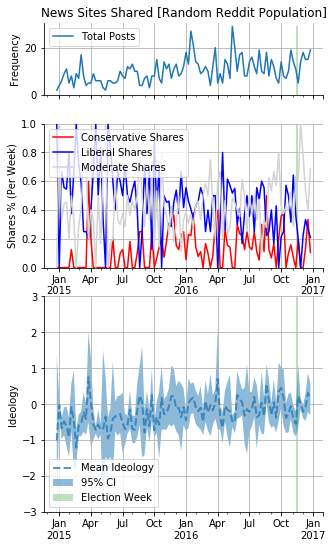

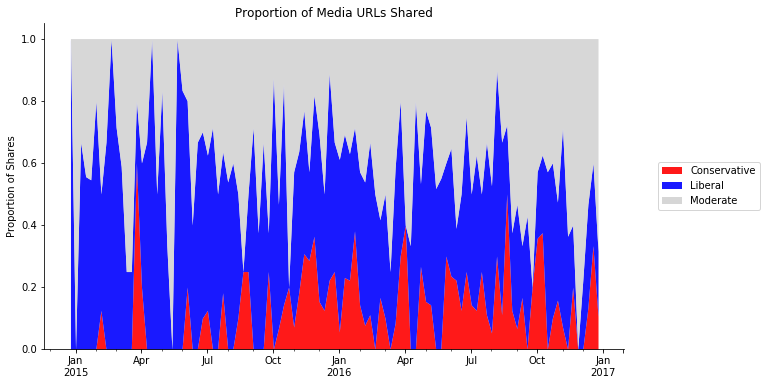

In [91]:

x, y_values, mean_ideo, labels = aggregate_timeseries(scored_random_links_df, freq=freq_level)

line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='News Sites Shared [Random Reddit Population]',
#           freq_lim=(0, 5000),
          figsize=(5,9),
          savefig="reddit_random_lineplot.pdf",
         )

porportion(x, y_values, "zero", 
           cmap=cmap_, 
           labels=labels,
           title="Proportion of Media URLs Shared",
          savefig="reddit_random_proportion.pdf",
          )


# # Plot number of unique users per day
# merged_w_scores.index = pd.to_datetime(merged_w_scores["tweet.created_at"])
# weekly_users = merged_w_scores.resample("w")["user.id"].nunique()
# fig, ax = plt.subplots(figsize=(16,6))
# ax.plot(weekly_users.index, weekly_users.values, label="Unique Users")

# # create legend
# box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # Hide the right and top spines
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)

# # Only show ticks on the left and bottom spines
# ax.yaxis.set_ticks_position('left')
# ax.xaxis.set_ticks_position('bottom')

# ax.set_ylabel("Unique Users Per Day")
# plt.grid()
# plt.show()

Conservative (9621, 9)
Liberal (29714, 9)
Moderate (28195, 9)


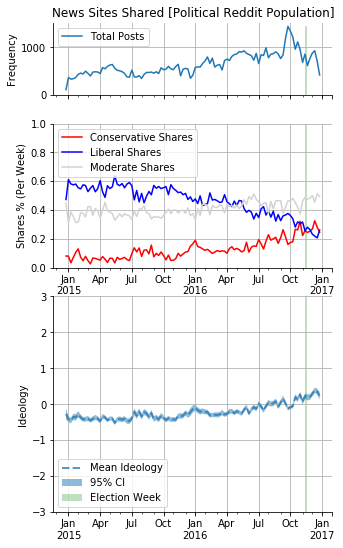

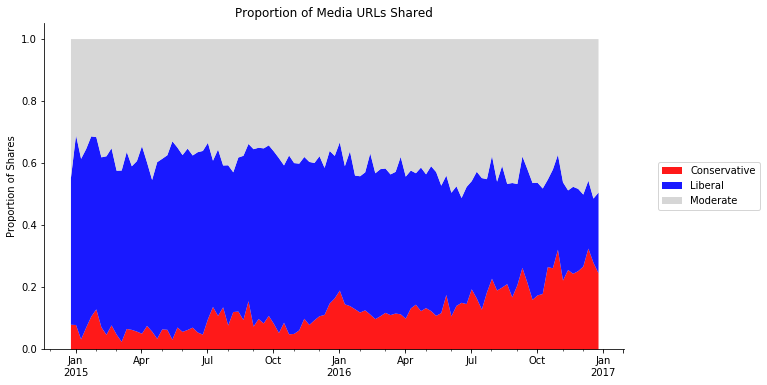

In [92]:

x, y_values, mean_ideo, labels = aggregate_timeseries(scored_political_links_df, freq=freq_level)

line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='News Sites Shared [Political Reddit Population]',
#           freq_lim=(0, 5000),
          figsize=(5,9),
          savefig="reddit_political_lineplot.pdf",
         )

porportion(x, y_values, "zero", 
           cmap=cmap_, 
           labels=labels,
           title="Proportion of Media URLs Shared",
          savefig="reddit_political_proportion.pdf",
          )

Conservative (454, 9)
Liberal (1186, 9)
Moderate (1089, 9)


/home/clb617/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


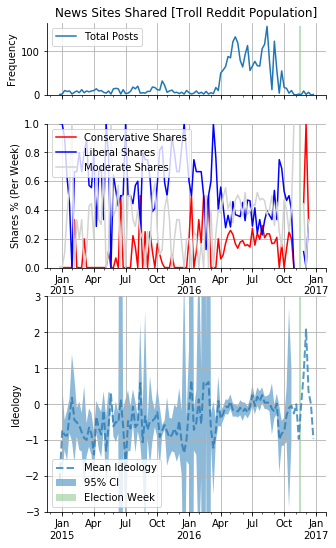

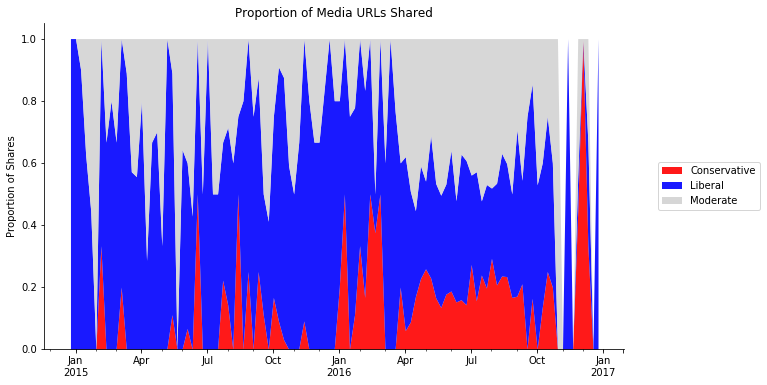

In [93]:
scored_troll_links_timed_df = scored_troll_links_df[scored_troll_links_df.date < datetime.datetime(2017,1,1)]
x, y_values, mean_ideo, labels = aggregate_timeseries(scored_troll_links_timed_df, freq=freq_level)

line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='News Sites Shared [Troll Reddit Population]',
#           freq_lim=(0, 5000),
          figsize=(5,9),
          savefig="reddit_troll_lineplot.pdf",
         )

porportion(x, y_values, "zero", 
           cmap=cmap_, 
           labels=labels,
           title="Proportion of Media URLs Shared",
          savefig="reddit_troll_proportion.pdf",
          )

# Analyze Differences Among Populations

How do political, random, and troll users behave in terms of URL sharing, and how different are they?

In [94]:
scored_links_df_rand = scored_random_links_df
scored_links_df_poli = scored_political_links_df
scored_links_df_ira = scored_troll_links_df

In [95]:
domains = sorted(mediascores_df.media_org)

In [96]:
def links_df_to_shares(links_df, domains):
    user_shares = []

    for user,user_posts in links_df.groupby("user_name"):
        local_tld_counts = dict(user_posts["tld"].value_counts().items())
        local_vector = [local_tld_counts.get(x, 0) for x in domains]
        user_shares.append([user] + local_vector)

    return pd.DataFrame(user_shares, columns=["user_name"] + domains)

user_tld_links_df_rand = links_df_to_shares(scored_links_df_rand, domains)
user_tld_links_df_poli = links_df_to_shares(scored_links_df_poli, domains)
user_tld_links_df_ira = links_df_to_shares(scored_links_df_ira, domains)

In [97]:
user_links_mat_rand = sklearn.preprocessing.normalize(user_tld_links_df_rand[domains], norm="l1", axis=1)
user_links_mat_poli = sklearn.preprocessing.normalize(user_tld_links_df_poli[domains], norm="l1", axis=1)
user_links_mat_ira = sklearn.preprocessing.normalize(user_tld_links_df_ira[domains], norm="l1", axis=1)

In [98]:
np.save("reddit_norm_share_rand", user_links_mat_rand)
np.save("reddit_norm_share_poli", user_links_mat_poli)
np.save("reddit_norm_share_ira", user_links_mat_ira)

In [99]:
rand_rand_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_rand, user_links_mat_rand)
poli_poli_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_poli, user_links_mat_poli)
rand_poli_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_rand, user_links_mat_poli)
ira_rand_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, user_links_mat_rand)
ira_poli_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, user_links_mat_poli)
ira_ira_sim = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, user_links_mat_ira)

rand_rand_sim_avg = (np.sum(rand_rand_sim, axis=1) - 1) / (user_links_mat_rand.shape[0] - 1)
poli_poli_sim_avg = (np.sum(poli_poli_sim, axis=1) - 1) / (user_links_mat_poli.shape[0] - 1)
rand_poli_sim_avg = (np.sum(rand_poli_sim, axis=1) - 1) / (user_links_mat_poli.shape[0] - 1)
ira_rand_sim_avg = (np.sum(ira_rand_sim, axis=1) - 1) / (user_links_mat_rand.shape[0] - 1)
ira_poli_sim_avg = (np.sum(ira_poli_sim, axis=1) - 1) / (user_links_mat_poli.shape[0] - 1)
ira_ira_sim_avg = (np.sum(ira_ira_sim, axis=1) - 1) / (user_links_mat_ira.shape[0] - 1)

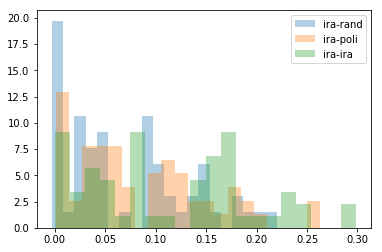

In [100]:
# plt.hist(rand_rand_sim_avg, bins=20, density=True, alpha=0.35, label="rand-rand")
# plt.hist(rand_poli_sim_avg, bins=20, density=True, alpha=0.35, label="rand-poli")
plt.hist(ira_rand_sim_avg, bins=20, density=True, alpha=0.35, label="ira-rand")
plt.hist(ira_poli_sim_avg, bins=20, density=True, alpha=0.35, label="ira-poli")
plt.hist(ira_ira_sim_avg, bins=20, density=True, alpha=0.35, label="ira-ira")

plt.legend()
plt.show()

In [101]:
print("Random->Random:", rand_rand_sim_avg.mean(), rand_rand_sim_avg.std())
print("Random->Poli:", rand_poli_sim_avg.mean(), rand_poli_sim_avg.std())
print("Poli->Poli:", poli_poli_sim_avg.mean(), poli_poli_sim_avg.std())
print("IRA->Random:", ira_rand_sim_avg.mean(), ira_rand_sim_avg.std())
print("IRA->Political:", ira_poli_sim_avg.mean(), ira_poli_sim_avg.std())
print("IRA->IRA:", ira_ira_sim_avg.mean(), ira_ira_sim_avg.std())

Random->Random: 0.0666557733782937 0.051068227056276866
Random->Poli: 0.06700247124715807 0.04780692571378827
Poli->Poli: 0.08135151284528233 0.05388588572698154
IRA->Random: 0.07052404576926671 0.061913707097774426
IRA->Political: 0.08412718322319 0.0660242144825435
IRA->IRA: 0.1132893994046991 0.08000794263199984


In [102]:
twitter_links_mat_rand = np.load("twitter_norm_share_rand.npy")
twitter_links_mat_poli = np.load("twitter_norm_share_poli.npy")
twitter_links_mat_ira = np.load("twitter_norm_share_ira.npy")

In [103]:
r2t_sim_rand = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_rand, twitter_links_mat_rand)
r2t_sim_poli = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_poli, twitter_links_mat_poli)
r2t_sim_ira = sklearn.metrics.pairwise.cosine_similarity(user_links_mat_ira, twitter_links_mat_ira)

r2t_sim_avg_rand = (np.sum(r2t_sim_rand, axis=1) - 1) / (twitter_links_mat_rand.shape[0] - 1)
r2t_sim_avg_poli = (np.sum(r2t_sim_poli, axis=1) - 1) / (twitter_links_mat_poli.shape[0] - 1)
r2t_sim_avg_ira = (np.sum(r2t_sim_ira, axis=1) - 1) / (twitter_links_mat_ira.shape[0] - 1)

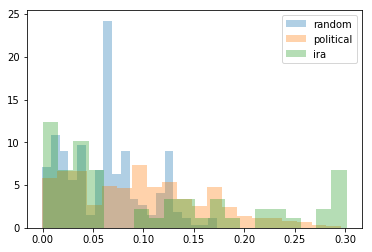

In [104]:
plt.hist(r2t_sim_avg_rand, bins=20, density=True, alpha=0.35, label="random")
plt.hist(r2t_sim_avg_poli, bins=20, density=True, alpha=0.35, label="political")
plt.hist(r2t_sim_avg_ira, bins=20, density=True, alpha=0.35, label="ira")

plt.legend()
plt.show()

In [105]:
print("Random:", r2t_sim_avg_rand.mean(), r2t_sim_avg_rand.std())
print("Political:", r2t_sim_avg_poli.mean(), r2t_sim_avg_poli.std())
print("IRA:", r2t_sim_avg_ira.mean(), r2t_sim_avg_ira.std())

Random: 0.061673550446290804 0.03901278102973703
Political: 0.09819106918157397 0.06567678007693642
IRA: 0.10882526214064918 0.10023256982038513


# Analyze Troll Ideology

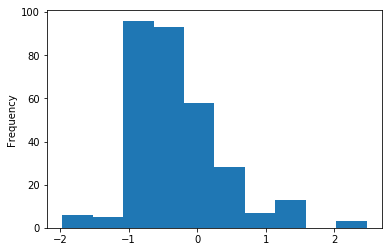

In [106]:
scored_random_links_df.groupby("user_name").describe()["zeta"]["mean"].plot.hist()

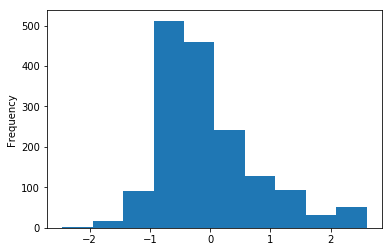

In [107]:
scored_political_links_df.groupby("user_name").describe()["zeta"]["mean"].plot.hist()

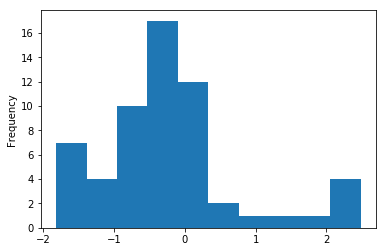

In [108]:
scored_troll_links_df.groupby("user_name").describe()["zeta"]["mean"].plot.hist()

In [109]:
ideologies_random = scored_random_links_df.groupby("user_name").describe()["zeta"]["mean"]
ideologies_political = scored_political_links_df.groupby("user_name").describe()["zeta"]["mean"]
ideologies_trolls = scored_troll_links_df.groupby("user_name").describe()["zeta"]["mean"]

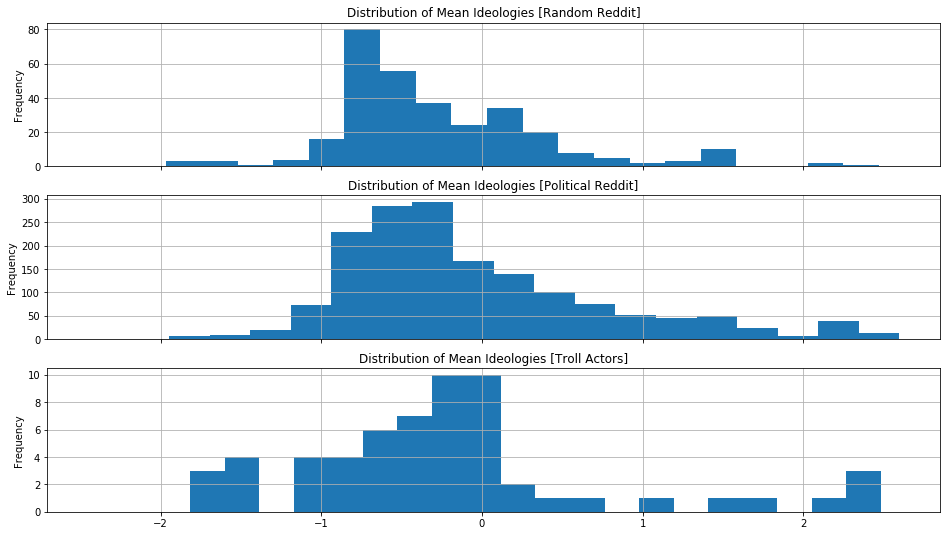

In [110]:
fig = plt.figure(figsize=(16,9))
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax3 = fig.add_subplot(3,1,3, sharex=ax1)

ideologies_random.plot.hist(bins=20, ax=ax1)
ideologies_political.plot.hist(bins=20, ax=ax2)
ideologies_trolls.plot.hist(bins=20, ax=ax3)

ax1.set_title("Distribution of Mean Ideologies [Random Reddit]")
ax2.set_title("Distribution of Mean Ideologies [Political Reddit]")
ax3.set_title("Distribution of Mean Ideologies [Troll Actors]")

ax1.grid()
ax2.grid()
ax3.grid()

plt.show()

Left-Leaning Count: 43
Right-Leaning Count: 16
Conservative (436, 9)
Liberal (1183, 9)
Moderate (1067, 9)


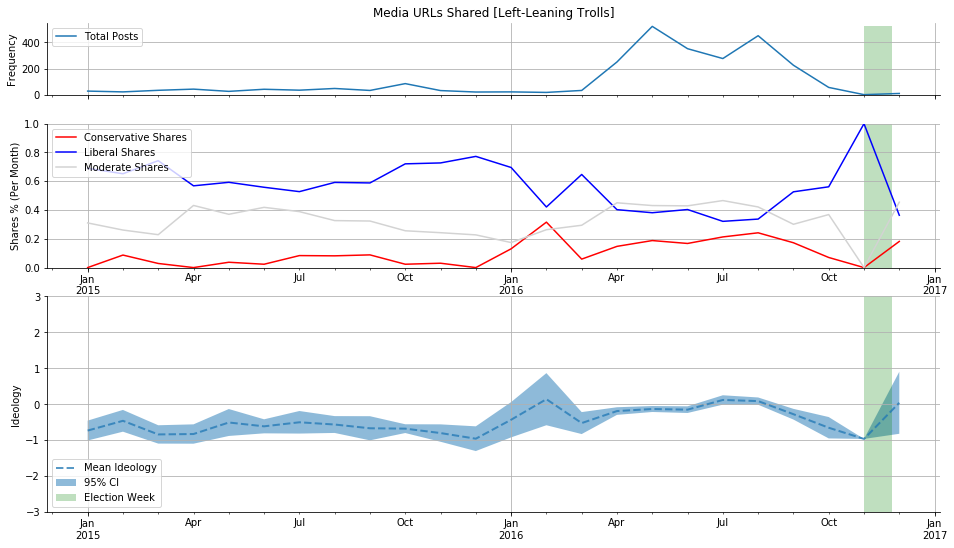

Conservative (18, 9)
Liberal (3, 9)
Moderate (22, 9)


/home/clb617/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


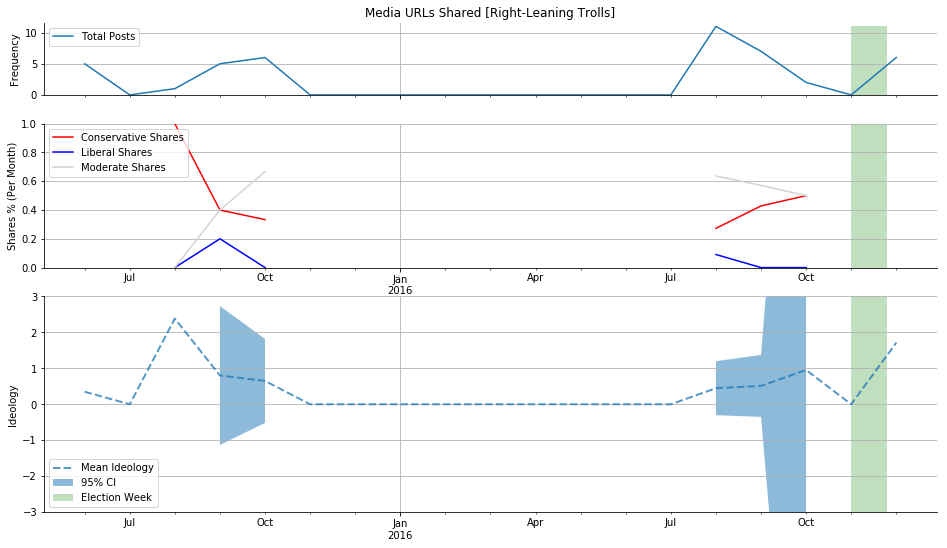

In [111]:
left_trolls = ideologies_trolls[ideologies_trolls < 0].index
right_trolls = ideologies_trolls[ideologies_trolls > 0].index

print("Left-Leaning Count:", left_trolls.shape[0])
print("Right-Leaning Count:", right_trolls.shape[0])

left_troll_df = scored_troll_links_df[scored_troll_links_df["user_name"].isin(left_trolls)]
right_troll_df = scored_troll_links_df[scored_troll_links_df["user_name"].isin(right_trolls)]

# Left Trolls
x, y_values, mean_ideo, labels = aggregate_timeseries(left_troll_df, freq="M")
line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='Media URLs Shared [Left-Leaning Trolls]',
#           savefig="reddit_troll_lineplot.pdf",
         )


x, y_values, mean_ideo, labels = aggregate_timeseries(right_troll_df, freq="M")
line_plot(x, y_values, color = iter(cmap_),
          labels=labels,
          means=mean_ideo, 
          title='Media URLs Shared [Right-Leaning Trolls]',
#           savefig="reddit_troll_lineplot.pdf",
         )